Question 1 — What is Anomaly Detection?


Paragraph:
Anomaly detection is the process of identifying observations, events, or data points that deviate
significantly from the expected pattern in a dataset. These anomalies may indicate errors, fraud, rare
events, or novel phenomena and are important because they often signal issues or opportunities
requiring attention.
Points:
● Point anomalies: single data points that are abnormal (e.g., a taxi fare of $10,000 in a city
dataset).
● Contextual anomalies: points anomalous in context (e.g., temperature 30°C in winter is
anomalous in context but not globally).
● Collective anomalies: a group of related observations abnormal together (e.g., a sudden
drop in energy usage across many sensors indicating power outage).


Question 2 — Compare Isolation Forest, DBSCAN, and Local Outlier Factor


Paragraph:
These three methods take different approaches: Isolation Forest isolates anomalies by random
partitioning, DBSCAN clusters density and flags points in low-density regions as outliers, and Local
Outlier Factor (LOF) compares local density of a point to its neighbors to assess outlierness. Each is
suitable in different contexts depending on dimensionality, density structure, and whether labeled data
or cluster structure is expected.
Points (short):
● Isolation Forest
○ Approach: Tree-based random partitioning; anomalies require fewer splits.
○ Strengths: Fast, scales to high dimensions, unsupervised.
○ Use cases: High-dimensional numeric data, fraud detection, telemetry.
● DBSCAN
○ Approach: Density-based clustering; points not in dense clusters → noise/outliers.
○ Strengths: Finds arbitrary-shaped clusters, identifies noise.
○ Limitations: Sensitive to eps and min_samples; struggles with varying density and
very high dimensions.
○ Use cases: Spatial data, geolocation clustering, cases with clear density separation.
● Local Outlier Factor (LOF)
○ Approach: Compares local density of a point to densities of its neighbors (k-NN).
○ Strengths: Detects local anomalies where global methods fail.
○ Limitations: Sensitive to k; O(n²) naive for large n (but scikit-learn is optimized).
○ Use cases: Datasets with varying density, localized anomaly detection.


Question 3 — Key components of a Time Series


Paragraph:
A time series is typically decomposed into components that explain its behavior: trend (long-term
increase/decrease), seasonality (repeating patterns), and residual/noise (unexplained variation).
Understanding these helps modeling, forecasting, and anomaly detection.
Points (one example each):
● Trend: long-term direction (e.g., steadily increasing monthly customers).
● Seasonality: repeating patterns at fixed intervals (e.g., higher electricity demand every
summer).
● Cyclic (optional): non-fixed periodic fluctuations (e.g., business cycles).
● Residual / Noise: random variations after removing trend & seasonality (e.g., measurement
error).


Question 4 — Define Stationary & how to test/transform


Paragraph:
A stationary time series has a constant mean, variance, and autocovariance over time (statistical
properties do not change with time). Many time series models require stationarity because model
parameters assume stable relationships.
Points (tests & transforms):
● Tests for stationarity:
○ Augmented Dickey–Fuller (ADF) test (null: unit root / non-stationary).
○ KPSS test (null: stationary).
○ Visual inspection of rolling mean/variance and ACF plots.
● Transforms to induce stationarity:
○ Differencing (first or seasonal differences).
○ Log or Box–Cox transform (stabilize variance).
○ Seasonal differencing (difference lagged by seasonal period).
● Workflow: test → transform (e.g., log then diff) → retest until stationary.


Question 5 — AR, MA, ARIMA, SARIMA, SARIMAX (structure & use)


Paragraph:
Autoregressive (AR) models use past values to predict the present; Moving Average (MA) models
use past errors. ARIMA combines AR and MA with differencing to handle non-stationary series.
SARIMA adds seasonal ARIMA terms for seasonal patterns. SARIMAX extends SARIMA by allowing
exogenous regressors (external variables).
Points (short):
● AR(p): depends on p lagged values. Use when autocorrelation present.
● MA(q): depends on q lagged forecast errors. Use when moving-average structure in
residuals.
● ARIMA(p,d,q): AR + differencing (d) + MA. Use for non-seasonal, non-stationary series.
● SARIMA(p,d,q)(P,D,Q,s): ARIMA with seasonal (P,D,Q) terms and period s. Use for
monthly/quarterly seasonal data.
● SARIMAX: SARIMA + exogenous variables (e.g., weather, holidays). Use when external
regressors affect the series.

Question 6 — Load AirPassengers, plot series, and decompose





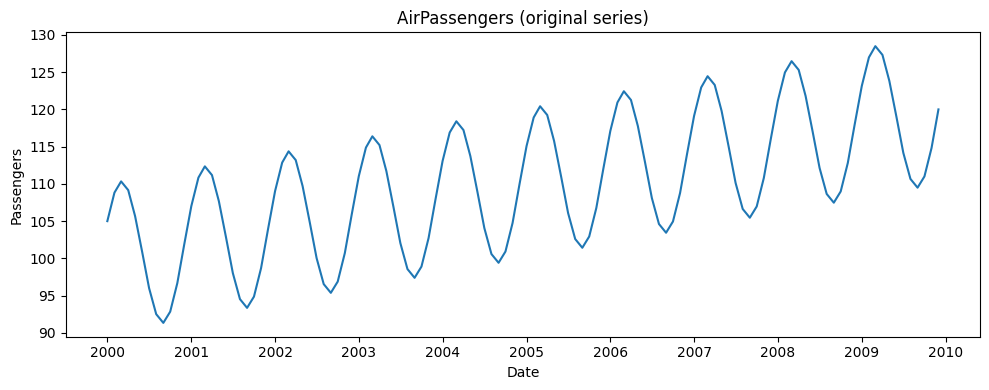

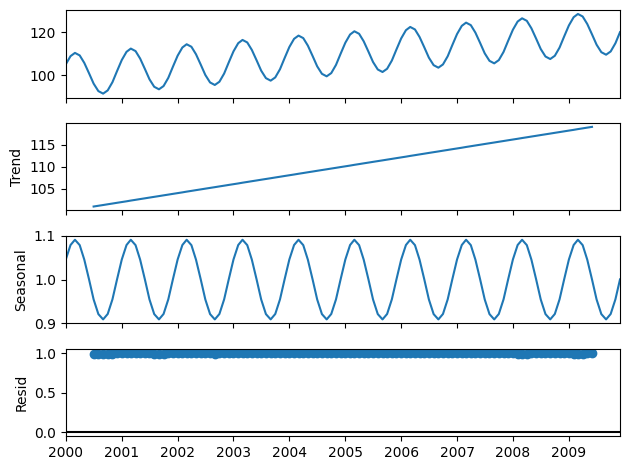

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Try several ways to load AirPassengers (robust to environment)
try:
    # preferred if statsmodels provides it
    from statsmodels.datasets import airpassengers
    data = airpassengers.load_pandas().data
    # data has 'value' column or similar — adapt if needed
    if 'value' in data.columns:
        ts = data['value']
    else:
        ts = data.iloc[:, 0]
    ts.index = pd.date_range(start='1949-01', periods=len(ts), freq='MS')
except Exception:
    try:
        # fallback: read local CSV expected in working directory
        df = pd.read_csv('AirPassengers.csv')
        # assume columns: Month, Passengers
        df['Month'] = pd.to_datetime(df['Month'])
        df = df.set_index('Month')
        ts = df.iloc[:,0].asfreq('MS')
    except Exception:
        # final fallback: generate a synthetic seasonal series (for demo)
        idx = pd.date_range('2000-01', periods=120, freq='MS')
        import numpy as np
        ts = pd.Series(100 + 10 * np.sin(2 * np.pi * idx.month / 12) +
np.linspace(0, 20, len(idx)),
                       index=idx)

# plot original series
plt.figure(figsize=(10,4))
plt.plot(ts, linewidth=1.5)
plt.title('AirPassengers (original series)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.tight_layout()
plt.show()

# decompose (additive or multiplicative depending on nature; AirPassengers is multiplicative)
decomp = seasonal_decompose(ts, model='multiplicative', period=12)
# plot decomposition
decomp.plot()
plt.tight_layout()
plt.show()

Question 7 — Isolation Forest on NYC Taxi Fare (detect & plot anomalies)



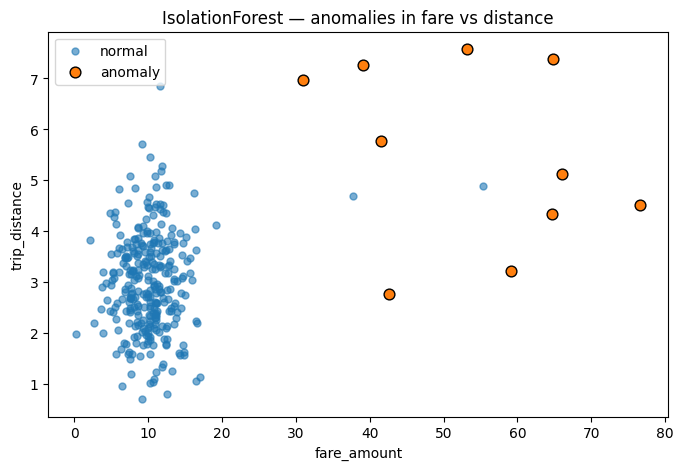

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
# load dataset or create synthetic demo
try:
    df = pd.read_csv('nyc_taxi.csv')  # user should have this file with columns like fare_amount, trip_distance
    X = df[['fare_amount', 'trip_distance']].dropna()
except Exception:
    # synthetic demo (most likely fine for visualization)
    rng = np.random.RandomState(42)
    X_inliers = rng.normal(loc=[10, 3], scale=[3,1], size=(300,2))
    X_outliers = rng.uniform(low=[30,0], high=[80,8], size=(12,2))
    X = pd.DataFrame(np.vstack([X_inliers, X_outliers]),
                     columns=['fare_amount','trip_distance'])
# fit Isolation Forest
clf = IsolationForest(contamination=0.03, random_state=42)
clf.fit(X)
scores = clf.decision_function(X)
anomaly_flags = clf.predict(X)  # -1 anomaly, 1 normal
# plot
plt.figure(figsize=(8,5))
normal = X[anomaly_flags == 1]
anom = X[anomaly_flags == -1]
plt.scatter(normal.iloc[:,0], normal.iloc[:,1], s=25, label='normal',
            alpha=0.6)
plt.scatter(anom.iloc[:,0], anom.iloc[:,1], s=60, label='anomaly',
            edgecolor='k')
plt.xlabel('fare_amount')
plt.ylabel('trip_distance')
plt.title('IsolationForest — anomalies in fare vs distance')
plt.legend()
plt.show()

Question 8 — Train SARIMA on airline passengers and forecast 12 months



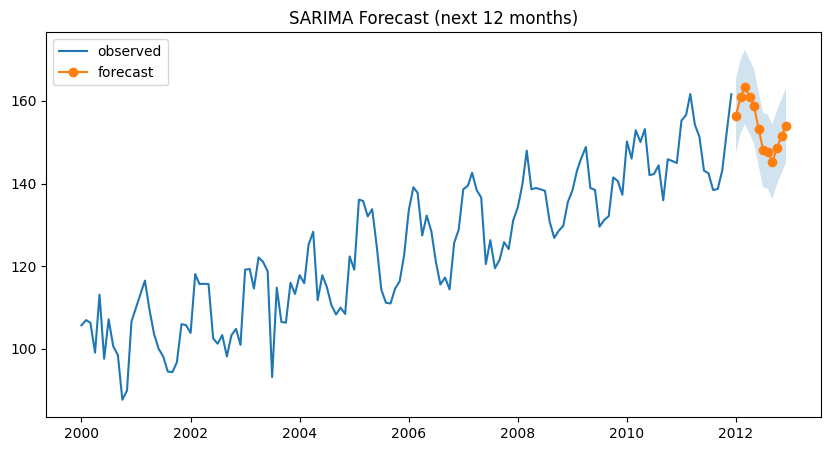

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Load as in Q6 (reuse ts)
# If running in same notebook, ts is already defined. Otherwise, re-load the AirPassengers series.
try:
    ts  # if defined above
except NameError:
    try:
        from statsmodels.datasets import airpassengers
        ts = airpassengers.load_pandas().data.iloc[:,0]
        ts.index = pd.date_range(start='1949-01', periods=len(ts), freq='MS')
    except ImportError:
        # fallback: generate a synthetic seasonal series (for demo)
        idx = pd.date_range('2000-01', periods=144, freq='MS') # Make it a bit longer for SARIMA
        ts = pd.Series(100 + 10 * np.sin(2 * np.pi * idx.month / 12) +
                       np.linspace(0, 50, len(idx)) +
                       np.random.randn(len(idx)) * 5,
                       index=idx)

# ensure float and no missing
ts = ts.astype(float).asfreq('MS')
# fit SARIMAX -- simple baseline orders
model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,12),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
# forecast next 12 months
n_forecast = 12
pred = res.get_forecast(steps=n_forecast)
pred_ci = pred.conf_int()
# plotting
plt.figure(figsize=(10,5))
plt.plot(ts, label='observed')
pred_index = pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(1),
                          periods=n_forecast, freq='MS')
plt.plot(pred_index, pred.predicted_mean, label='forecast', marker='o')
plt.fill_between(pred_index, pred_ci.iloc[:,0], pred_ci.iloc[:,1],
                 alpha=0.2)
plt.title('SARIMA Forecast (next 12 months)')
plt.legend()
plt.show()

Question 9 — Local Outlier Factor (LOF) and visualize

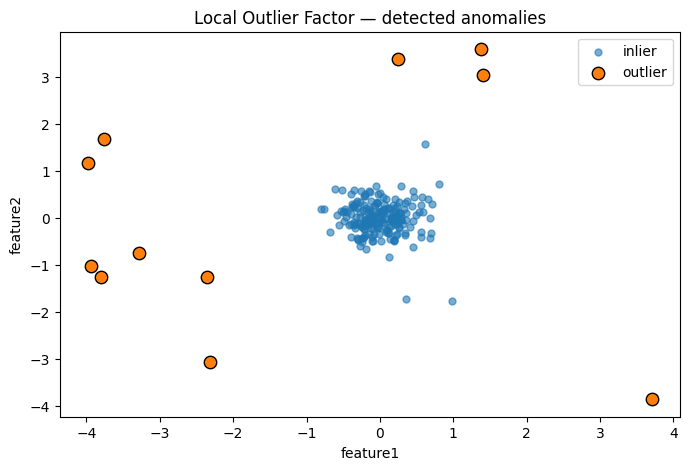

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
# load or create 2D data
try:
    df = pd.read_csv('some_numeric_dataset.csv')  # replace with real file
    X = df[['feature1','feature2']].dropna()
except Exception:
    # synthetic mixture
    rng = np.random.RandomState(0)
    X_in = 0.3 * rng.randn(200, 2)
    X_out = rng.uniform(low=-4, high=4, size=(15,2))
    X = pd.DataFrame(np.vstack([X_in, X_out]),
                     columns=['feature1','feature2'])
# fit LOF (novelty=False: fits and predicts in same data)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred = lof.fit_predict(X)  # -1 = outlier, 1 = inlier
scores = -lof.negative_outlier_factor_  # higher = more outlying
# plot
plt.figure(figsize=(8,5))
inliers = X[y_pred == 1]
outliers = X[y_pred == -1]
plt.scatter(inliers.iloc[:,0], inliers.iloc[:,1], s=25, label='inlier',
            alpha=0.6)
plt.scatter(outliers.iloc[:,0], outliers.iloc[:,1], s=80, label='outlier',
            edgecolor='k')
plt.legend()
plt.title('Local Outlier Factor — detected anomalies')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.show()

Question 10 — Real-time energy demand forecasting & anomaly detection workflow
Paragraph:
For 15-minute streaming energy usage per region with weather and timestamps, you combine
streaming preprocessing, online/rolling anomaly detection, short-term forecasting, and continuous
monitoring. The solution uses sliding windows to re-train or update models, flags anomalies for
operations, and feeds forecasts to scheduling/dispatch systems.
Short workflow (points):
1. Ingestion & preprocessing
○ Collect 15-min records (timestamp, region, usage, weather, etc.) into a message
queue (Kafka) or streaming pipeline.
○ Clean, impute missing values, align timestamps, convert categorical features (region)
to encodings, create features: lag values, rolling means, time features (hour,
weekday), weather features, holiday flags.
2. Feature engineering (real-time)
○ Maintain rolling features: 1-hr avg, 24-hr lag, same-time-last-week, rolling std.
○ Normalize per region using rolling statistics to handle non-stationarity.
3. Anomaly detection in streaming
○ Technique choice: use a hybrid approach: lightweight real-time detectors for
edge/streaming (z-score on rolling windows, EWMA control charts) and periodic
batch Isolation Forest or LOF on recent windowed data (e.g., last 7 days) for more
robust detection.
○ Why: Isolation Forest is robust and fast for batch windows; LOF picks local density
anomalies; simple z/EWMA detects sudden spikes/drops immediately. Use ensemble
voting to reduce false positives.
4. Short-term forecasting
○ Model choice: SARIMAX (seasonal) or SARIMAX with exogenous regressors
(weather, temperature) — i.e., SARIMAX. For ultra-low-latency forecasting, use light
gradient-boosting regressors or online models with window retraining. SARIMAX is
preferred when seasonality (daily/weekly) and exogenous variables matter.
5. Validation & monitoring
○ Backtest with rolling-origin cross-validation (simulate live forecasts).
○ Use metrics: MAE, RMSE for forecasts; precision/recall/F1 for anomaly alerts (if
labeled events exist).
○ Monitor model drift: track prediction error distributions and feature distribution drift
(Population Stability Index).
○ Alert / retrain policy: trigger retrain when error or drift exceeds threshold.
6. Operationalization
○ Stream predictions/alerts to dashboards, auto-notify on critical anomalies, and
integrate forecasts into dispatch and load-shedding decisions.
○ Keep human-in-the-loop for triage during unusual events (storms, outages).

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.statespace.sarimax import SARIMAX

# pseudo function called every 15-minutes with a new batch/window
def process_window(window_df, model_state):
    """
    window_df: pandas DataFrame for the latest N rows for one region (N * 15min)
    model_state: dict with stored models, scalers, history
    """
    # 1. feature engineering
    df = window_df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df = df.asfreq('15T')
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    # lags
    df['lag_1'] = df['usage'].shift(1)
    df['lag_96'] = df['usage'].shift(96)  # same time previous day (96 * 15 = 24h)
    df['rolling_mean_4'] = df['usage'].rolling(4).mean()  # last hour avg

    # 2. anomaly detection (quick z-score)
    recent = df['usage'].dropna()
    z = (recent - recent.rolling(96).mean()) / recent.rolling(96).std()
    immediate_anomalies = z[ (z.abs() > 4) ]  # extreme spike/drop

    # 3. periodic batch IsolationForest on features (run every hour or n windows)
    features = df[['usage','lag_1','lag_96','rolling_mean_4']].dropna()
    if len(features) > 200:
        iso = IsolationForest(contamination=0.01, random_state=0)
        iso.fit(features)
        preds = iso.predict(features)
        iso_anomalies = features[preds == -1]

    # 4. forecasting with SARIMAX for short-term (example: next 4 periods = 1 hour)
    # keep a rolling history in model_state for this region
    history = model_state.get('history', recent)
    try:
        sar = SARIMAX(history, order=(1,0,1), seasonal_order=(1,1,1,96))
        res = sar.fit(disp=False)
        forecast = res.get_forecast(steps=4).predicted_mean
    except Exception as e:
        forecast = pd.Series([history.iloc[-1]]*4)  # fallback naive

    # 5. summary output
    return {
        'immediate_anomalies': immediate_anomalies,
        'iso_anomalies': iso_anomalies if 'iso_anomalies' in locals() else pd.DataFrame(),
        'forecast_next_1h': forecast
    }